# Get the Data

In [65]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
# Import the dataset
df = pd.read_csv('library_dataset.csv')
df.sample(10)

,checking_hour,hour,minute,day_of_week,room,status
9547,6,13,15,Thursday,436,Unavailable
15428,6,14,45,Saturday,306,Available
145,6,20,30,Monday,358,Available
7301,6,15,45,Wednesday,520D,Unavailable
17169,12,15,0,Sunday,514C,Available
8505,12,17,15,Wednesday,437,Unavailable
7846,12,18,0,Wednesday,514A,Unavailable
7700,6,19,45,Wednesday,514A,Unavailable
11794,12,18,0,Thursday,358,Unavailable
11423,12,15,30,Thursday,306,Unavailable


<AxesSubplot:>

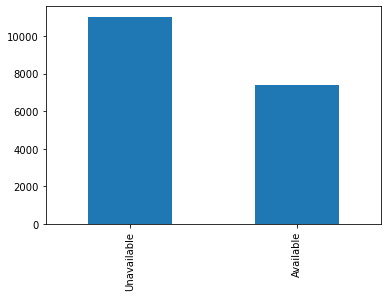

In [67]:
# Check the distribution of the target variable
df.status.value_counts().plot(kind='bar')

In [68]:
# Check the size and type of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18417 entries, 0 to 18416
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   checking_hour  18417 non-null  int64 
 1   hour           18417 non-null  int64 
 2   minute         18417 non-null  int64 
 3   day_of_week    18417 non-null  object
 4   room           18417 non-null  object
 5   status         18417 non-null  object
dtypes: int64(3), object(3)
memory usage: 863.4+ KB


In [69]:
df.shape

(18417, 6)

In [70]:
# Convert the target variable to numeric data
df['status'] = df['status'].apply(lambda x: 0 if x=='Unavailable' else 1)

In [71]:
# Sample a test set and put it aside
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=101)

Exploratory Data Analysis

In [72]:
# Create a copy of the data for exploration
train_copy = train_set.copy()

<function matplotlib.pyplot.show(close=None, block=None)>

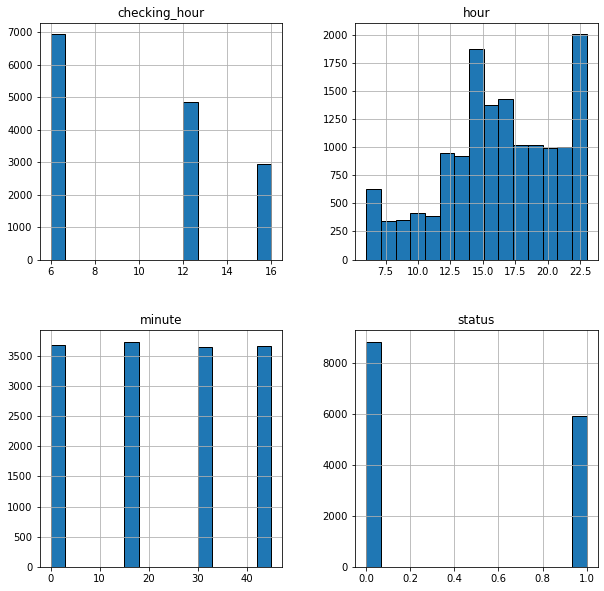

In [73]:
# Distribution of numeric data
train_copy.hist(bins=15, edgecolor='black', figsize=(10,10))
plt.show

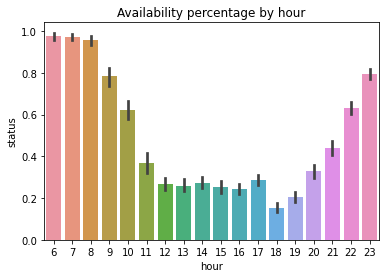

In [74]:
sns.barplot(data=train_copy, x='hour', y='status')
plt.title("Availability percentage by hour")
plt.show()

We can see that most rooms are not available from 11 am to 7pm. This makes total sense because this is the time that students study

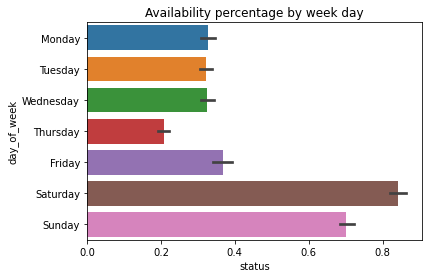

In [75]:
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(data=train_copy, y='day_of_week', x='status', orient='h', order=day_of_week)
plt.title('Availability percentage by week day')
plt.show()

We can see that rooms are more likely to be available at the weekend.

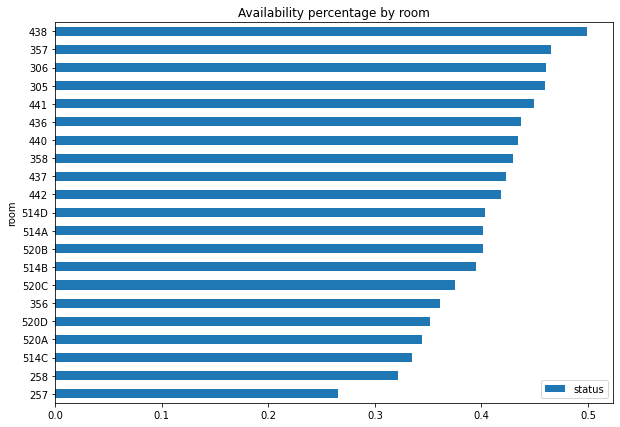

In [76]:
train_copy.groupby('room')['status'].mean().reset_index().sort_values(by='status').plot(kind='barh', x='room', y='status', figsize=(10,7))
plt.title('Availability percentage by room')
plt.show()

We can see that room on floor 3 and 4 are more likely to be available than rooms on floor 5 and 2. Why is that? My hypothesis is that the number of room in floor 3 and 4 is larger than the number of room 2 and 5. Therefore, there are more rooms available

Let's create a floor variable

In [77]:
# Create a floor variable
train_copy['room'] = train_copy['room'].astype(str)
train_copy['floor'] = train_copy['room'].apply(lambda train_copy: list(train_copy)[0])

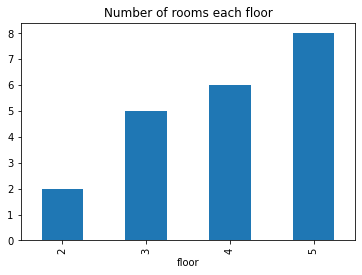

In [78]:
train_copy.groupby('floor')['room'].nunique().plot(kind='bar')
plt.title('Number of rooms each floor')
plt.show()

It is true that the number of rooms on floor 3 and 4 is higher than floor 2. However, floor 5 has the most rooms. It might be that because floor 5 is the most quiet floor, so studetns tend to reserve that room for studying

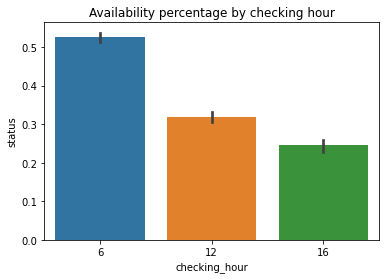

In [79]:
sns.barplot(data=train_copy, x='checking_hour', y='status')
plt.title('Availability percentage by checking hour')
plt.show()

It makes total sense since when we check room availability a 6 am, many rooms are still available. However, later in the day, rooms will be booked so rooms availability when checking at 12 pm and 4 pm are less likely to be available

<AxesSubplot:>

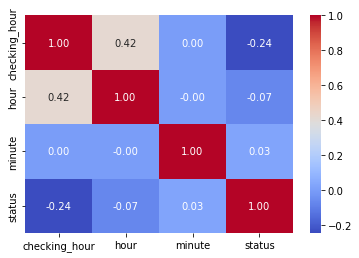

In [80]:
sns.heatmap(train_copy.corr(), cmap='coolwarm', annot=True, fmt='.2f')

# Feature Engineering and Machine Learning

In [81]:
X_train = train_set.drop('status', axis=1)
X_test = test_set.drop('status', axis=1)
y_train = train_set['status']
y_test = test_set['status']

In [82]:
num = X_train.drop(['day_of_week', 'room'], axis=1)
cat = X_train[['day_of_week', 'room']]

In [83]:
# Models Dictionary 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb

model_dict = {
    'Logreg': LogisticRegression(),
    'sgd': SGDClassifier(),
    'naive': GaussianNB(),
    'knn': KNeighborsClassifier(),
    'tree': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'adaboost': AdaBoostClassifier(),
    'svm': SVC(),
    'gbc': GradientBoostingClassifier(),
    'quadra': QuadraticDiscriminantAnalysis(),
    'xgb': xgb.XGBClassifier(objective="binary:logistic")
}

In [84]:
def train_and_score(model_dict, X, y, scoring=None, save_model = False):
    """Train model in a model dictionary, calculate the score and return a datafame.
    Parameters
    --------
    model_dict: dict
        A dictionary with the key containing the name of the model and the values 
        containining the model
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The training input samples. Internally, its dtype will be converted to `dtype=np.float32`. 
        If a sparse matrix is provided, it will be converted into a sparse `csc_matrix`.
    y : array-like of shape (n_samples,) or (n_samples, n_outputs)
        The target values (class labels in classification, real numbers in regression).
    scoring: default = `neg_mean_squared_error`
        The scoring method
    save_model: default = False
        If True, the model is saved to a pickle file
    Return 
    --------
    score_df: `pd.DataFrame`
        This dataframe containing columns of model, mean score, and standard deviation    
    """
    from sklearn.model_selection import cross_val_score
    score_df = pd.DataFrame(columns=['Model', 'Score', 'Std'])
    for name, model in model_dict.items():
        # Train the model
        model.fit(X, y)
        # Calculate the score
        if scoring == None:
            scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error') 
            scores = np.sqrt(-scores)
        else:
            scores = cross_val_score(model, X, y, scoring=scoring)       
        
        # Add the score to the score_df
        adding_df = pd.DataFrame({'Model': [name], 'Score': [scores.mean()], 'Std':[scores.std()]})
        score_df = pd.concat([score_df, adding_df])  
        # Print information      
        print('{}:'.format(name))
        print("Scores:", scores)
        print("Mean:", scores.mean())
        print("Standard deviation:", scores.std())
        print('---------------------')
        # Save the results
        if save_model == True:
            import pickle
            with open(f'{name}_baseline.pkl','wb') as f:
                pickle.dump(model,f)
        
    # Sort the dataset and reset the index
    score_df = score_df.sort_values(by='Score').reset_index(drop=True)
    # Return the result
    return score_df

# With Polynomial Features

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
num_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline([
    ('encode', OneHotEncoder())
])

from sklearn.compose import ColumnTransformer
num_attribs = list(num)
cat_attribs = ['day_of_week', 'room']
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [86]:
X_train_prepared = full_pipeline.fit_transform(X_train)

In [87]:
score_df_poly = train_and_score(model_dict, X_train_prepared, y_train, scoring='accuracy')

c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Logreg:
Scores: [0.84526637 0.83915847 0.83949779 0.84521385 0.84860828]
Mean: 0.8435489529780593
Standard deviation: 0.0036607781714437463
---------------------
sgd:
Scores: [0.84051578 0.84051578 0.83610451 0.8401222  0.82043449]
Mean: 0.8355385515227034
Standard deviation: 0.007733155575788748
---------------------
naive:
Scores: [0.76247031 0.75839837 0.76179165 0.76816022 0.75526137]
Mean: 0.7612163842272544
Standard deviation: 0.0043248919760266995
---------------------
knn:
Scores: [0.8347472  0.83203258 0.82863929 0.82620502 0.82552614]
Mean: 0.8294300462274107
Standard deviation: 0.003501766797342111
---------------------
tree:
Scores: [0.91856125 0.92297251 0.91788259 0.91581806 0.91547862]
Mean: 0.9181426058142828
Standard deviation: 0.002685935718382643
---------------------
rfc:
Scores: [0.91279267 0.90363081 0.89243298 0.90054311 0.90495587]
Mean: 0.9028710891741888
Standard deviation: 0.0065990125267701705
---------------------
adaboost:
Scores: [0.84628436 0.84051578 0.

c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


quadra:
Scores: [0.83338989 0.8347472  0.83746183 0.83435166 0.83944331]
Mean: 0.8358787780777902
Standard deviation: 0.0022369206263811174
---------------------
xgb:
Scores: [0.92908042 0.92195453 0.92093655 0.91310251 0.92057026]
Mean: 0.9211288546166709
Standard deviation: 0.005073072583999438
---------------------


In [88]:
score_df_poly

,Model,Score,Std
0,naive,0.761216,0.004325
1,knn,0.829430,0.003502
2,sgd,0.835539,0.007733
3,quadra,0.835879,0.002237
4,adaboost,0.842870,0.004506
5,Logreg,0.843549,0.003661
6,gbc,0.859432,0.003530
7,svm,0.862418,0.004641
8,rfc,0.902871,0.006599
9,tree,0.918143,0.002686


<AxesSubplot:ylabel='Model'>

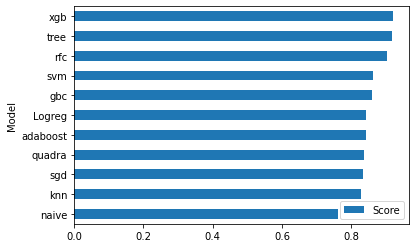

In [89]:
score_df_poly.plot(kind='barh', x='Model', y='Score')

# Without polynomial features

In [90]:
num_pipeline = Pipeline([
    # ('poly', PolynomialFeatures()),
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline([
    ('encode', OneHotEncoder())
])

from sklearn.compose import ColumnTransformer
num_attribs = list(num)
cat_attribs = ['day_of_week', 'room']
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [91]:
X_train_prepared = full_pipeline.fit_transform(X_train).toarray()

In [92]:
score_df = train_and_score(model_dict, X_train_prepared, y_train, scoring='accuracy')

Logreg:
Scores: [0.70885646 0.70071259 0.70851714 0.71486762 0.69755601]
Mean: 0.7061019629199359
Standard deviation: 0.006202188733672686
---------------------
sgd:
Scores: [0.70614184 0.7068205  0.70410587 0.70739986 0.71215207]
Mean: 0.707324027956215
Standard deviation: 0.0026579465956459956
---------------------
naive:
Scores: [0.74686121 0.72650153 0.73057346 0.74541752 0.73625255]
Mean: 0.7371212534822599
Standard deviation: 0.008001269776476331
---------------------
knn:
Scores: [0.87376994 0.85714286 0.86019681 0.86116768 0.86320434]
Mean: 0.8630963265714199
Standard deviation: 0.005683454005853301
---------------------
tree:
Scores: [0.91991856 0.93077706 0.91143536 0.92260692 0.92226748]
Mean: 0.9214010773264999
Standard deviation: 0.006190754673432795
---------------------
rfc:
Scores: [0.93892094 0.92840176 0.92874109 0.9287169  0.93041412]
Mean: 0.9310389637614603
Standard deviation: 0.004003571293540441
---------------------
adaboost:
Scores: [0.84492704 0.84187309 0.839

c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


xgb:
Scores: [0.93111639 0.92874109 0.92263319 0.9185336  0.92192804]
Mean: 0.9245904622764103
Standard deviation: 0.0046350925080252455
---------------------


In [93]:
score_df

,Model,Score,Std
0,Logreg,0.706102,0.006202
1,sgd,0.707324,0.002658
2,quadra,0.716623,0.013141
3,naive,0.737121,0.008001
4,adaboost,0.842055,0.003703
5,gbc,0.859567,0.003841
6,knn,0.863096,0.005683
7,svm,0.880269,0.002462
8,tree,0.921401,0.006191
9,xgb,0.924590,0.004635


<AxesSubplot:ylabel='Model'>

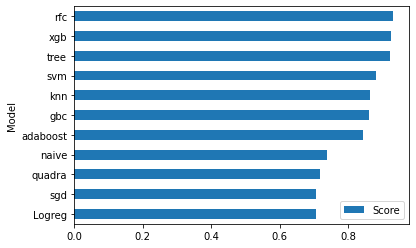

In [94]:
score_df.plot(kind='barh', x='Model', y='Score')

The 3 most promising models are rfc, xgb, and tree. Polynomial features do not work

# With Floors

In [95]:
from sklearn.base import BaseEstimator, TransformerMixin
class AddFloors(BaseEstimator, TransformerMixin):
    # def __init__(self, add_floors = True):
    #     self.add_floors = add_floors
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['room'] = X['room'].astype(str)
        X['floor'] = X['room'].apply(lambda x: list(x)[0])
        return X.astype(str)

In [96]:
num_pipeline = Pipeline([
    # ('poly', PolynomialFeatures()),
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline([
    ('floors', AddFloors()),
    ('encode', OneHotEncoder(drop='first'))
])

from sklearn.compose import ColumnTransformer
num_attribs = list(num)
cat_attribs = ['day_of_week', 'room']
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [97]:
X_train_prepared = full_pipeline.fit_transform(X_train).toarray()

In [98]:
score_df_floor = train_and_score(model_dict, X_train_prepared, y_train, scoring='accuracy')

Logreg:
Scores: [0.70885646 0.70139125 0.70885646 0.7155465  0.69721656]
Mean: 0.7063734484607104
Standard deviation: 0.006405412447750405
---------------------
sgd:
Scores: [0.70614184 0.7068205  0.70410587 0.70739986 0.71215207]
Mean: 0.707324027956215
Standard deviation: 0.0026579465956459956
---------------------
naive:
Scores: [0.74346793 0.72310825 0.73396675 0.73082145 0.73794976]
Mean: 0.7338628280431087
Standard deviation: 0.006839340423573355
---------------------
knn:
Scores: [0.87478792 0.8588395  0.86291144 0.8604888  0.86625933]
Mean: 0.8646573972265396
Standard deviation: 0.005647428560404907
---------------------
tree:
Scores: [0.92025789 0.91652528 0.90804208 0.91785472 0.92023082]
Mean: 0.9165821571455524
Standard deviation: 0.004502874186765537
---------------------
rfc:
Scores: [0.93281303 0.92500848 0.92297251 0.91921249 0.92803802]
Mean: 0.9256089073979752
Standard deviation: 0.004604892512824121
---------------------
adaboost:
Scores: [0.84390906 0.84017645 0.839

c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Kha Do\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


xgb:
Scores: [0.9239905  0.91957923 0.92297251 0.91683639 0.9239647 ]
Mean: 0.9214686665141649
Standard deviation: 0.002824157542371312
---------------------


In [99]:
score_df_floor

,Model,Score,Std
0,quadra,0.694425,0.025199
1,Logreg,0.706373,0.006405
2,sgd,0.707324,0.002658
3,naive,0.733863,0.006839
4,adaboost,0.841377,0.003228
5,gbc,0.857395,0.004422
6,knn,0.864657,0.005647
7,svm,0.878572,0.003037
8,tree,0.916582,0.004503
9,xgb,0.921469,0.002824


<AxesSubplot:ylabel='Model'>

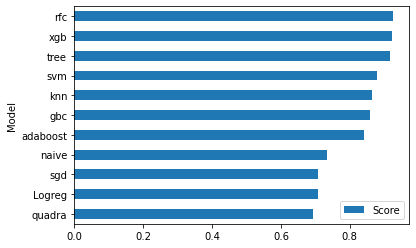

In [100]:
score_df_floor.plot(kind='barh', x='Model', y='Score')

The original dataset performs the best. The three most promising models are Random Forest, Xgboost and Decision Tree.

# Tune Random Forest Classifier using the original dataset

In [101]:
num_pipeline = Pipeline([
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline([
    ('encode', OneHotEncoder())
])

from sklearn.compose import ColumnTransformer
num_attribs = list(num)
cat_attribs = ['day_of_week', 'room']
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [102]:
X_train_prepared = full_pipeline.fit_transform(X_train)

In [103]:
# We will tune the three models
from sklearn.model_selection import GridSearchCV
# Random Forest Classifier
rfc = RandomForestClassifier()
param_grid = [{
    'bootstrap': [True, False],
    'max_depth': [10, 30, 50, 100],
    'max_features': ['log2', 'sqrt'],
    'n_estimators': [10, 50, 100]
}]
grid_search = GridSearchCV(rfc, param_grid, cv = 5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [10, 30, 50, 100],
                          'max_features': ['log2', 'sqrt'],
                          'n_estimators': [10, 50, 100]}],
             return_train_score=True, scoring='accuracy')

In [104]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [105]:
X_test_prepared = full_pipeline.transform(X_test)

In [106]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = grid_search.predict(X_test_prepared)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[2144   64]
 [ 155 1321]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2208
           1       0.95      0.89      0.92      1476

    accuracy                           0.94      3684
   macro avg       0.94      0.93      0.94      3684
weighted avg       0.94      0.94      0.94      3684



In [107]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predictions))

0.9405537459283387
